Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Luis Grau"
COLLABORATORS = ""

---

# **Practice 12: Solving PDEs with finite differences**

## Practice guide

In this second graded practice you have to solve th_e exercises below. The codes you need to solve this problems are similar, but not the same, to some of the codes from the regular practices.

You will have to handle a notebook with:

* The working programs that solve the exercises. I will run all the codes.
* An explanation of the methods you are using.
* An explanation of your procedure to calculate the solutions.
* An explanation of the results.

## 1- Temperature around a radiactive rod

Let us suppose that we want to calculate the change in temperature around a radiactive rod buried on the ground. The temperature $T$ fulfills the following equation in polar coordinates:

$$\frac{1}{\kappa}\frac{\partial T}{\partial t}-\frac{\partial^2 T}{\partial r^2}-\frac{1}{r}\frac{\partial T}{\partial r} = S(r, t)$$

where the source term due to the radioactive decay of rod is given by:

$$ S(r, t) = \left\{\begin{array}{l}
T_{rod}e^{−t/\tau_0} /a^2 \quad \textrm{for}\; r \leq a \\
0 \qquad \qquad \quad \textrm{elsewhere}.
\end{array}\right.$$

where the radius of the rod is $a = 25\;cm$, the diffusion coefficient is $\kappa = 2 \cdot 10^7 \;cm^2/year$, the rod's temperature is  $T_{rod} = 1K$, final time $\tau_0 = 100\; years$, the radius of the domain where we want to solve the equation is $r_c = 100\;cm$, the environment's temperature is $T_E = 300\;K$, $0 < r < r_c$ and $0 < t < \tau_0$. Initially $T(r, t = 0) = 3$.

This is complemented with the boundary conditions

$$ \frac{\partial T}{\partial r}(r = 0, t) = 0 \; \textrm{ and } \; T(r = r_c, t) = 300K$$

**Exercises:** 

1. Solve this equation using a finite differences method.


## 2- Wave equation

This is the wave equation with the corresponding initial conditions and periodic boundary conditions

$$\begin{array}{l}
u_{tt}=u_{xx} \\
u(x,0) = \sin{(4\pi x)} \\
u_t(x,0)=0 \\
u(0,t)=u(1,t)=0
\end{array} $$



**Exercises:**

1. Solve the equation using finite differences.
2. Solve the equation up to time $t=100$ with different time-steps $\Delta t$ bigger, equal and smaller than the $\Delta x$. Explain the results.

# Solution

### Imports

In [2]:
from typing import Callable, Tuple

import numpy as np
from numba import njit

import matplotlib.pyplot as plt
from matplotlib.animation import  FuncAnimation

plt.rcParams['animation.html']='jshtml'


### Utilmethods

In [3]:
def run_animation(dt, x, y, xlim, ylim):

    fig = plt.figure()
    ax = plt.axes(xlim=xlim, ylim=ylim)
    line, = ax.plot([], [])

    def init():
        line.set_data([], [])
        return line,

    def animate(i, *fargs):
        line.set_data(fargs[0], fargs[1][:, i])
        return line,

    return FuncAnimation(fig, animate, fargs=[x, y], init_func=init, frames=len(x), interval=dt, blit=True)


## Question 1

## Deducing a solution with finite differences

The equation to solve is the next one:

$$\frac{1}{\kappa}\frac{\partial T}{\partial t}-\frac{\partial^2 T}{\partial r^2}-\frac{1}{r}\frac{\partial T}{\partial r} = S(r, t)$$

Defining $\frac{\partial T}{\partial t}$ with backward differences method:

$$ \frac{\partial T}{\partial t} = \frac{T(r, t) - T(r, t-k)}{k} $$

Where k is the time step of the time mesh.

Similarly, defining $\frac{\partial T}{\partial r}$ with finite backward differences method:

$$ \frac{\partial T}{\partial r} = \frac{T(r, t) - T(r-h, t)}{h} $$

Where h is the space step of the space mesh.

Lastly, defining $\frac{\partial^2 T}{\partial r^2}$ with central differences method:

$$ \frac{\partial^2 T}{\partial t^2} = \frac{T(r-h, t) - 2T(r, t) + T(r+h, t)}{h^2} $$

Where h is the space step of the space mesh.

Applying these changes to our equation it becomes

$$ \frac{1}{Kk} \left[ T_{r,t} - T_{r,t-k} \right] - \frac{1}{h^2} \left[ T_{r-h,t} - 2T_{r,t} + T_{r+h,t} \right] - \frac{1}{rh} \left[ T_{r,t} - T_{r-h,t} \right] = S(r,t) $$ 

By setting $s=kK$ and by reorganizing the terms, we get:

$$ \left(-\frac{1}{h^2} + \frac{1}{rh} \right)T_{r-h,t} + \left(\frac{1}{s} + \frac{2}{h^2} - \frac{1}{rh} \right)T_{r,t} + \left(-\frac{1}{h^2} \right)T_{r+h,t}  = T_{r,t-k}/s + S_{r,t}$$


$$ v_1 \cdot T_{r-h,t} + v_2 \cdot T_{r,t} + v_3 \cdot T_{r+h,t}  = T_{r,t-k}/s + S_{r,t}$$


Therefore, in matricial form:

$$ \mathbf{m} \cdot T_{r,t}  = \left(
                                        \begin{array}{ccc}
                                        v_2 & v_3 & 0 & \ldots & \ldots & \ldots & 0\\
                                        v_1 & v_2 & v_3 &0 & \ldots & \ldots & 0 \\
                                        0 & v_1 & v_2 & v_3 & \ldots & \ldots & 0 \\
                                        \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
                                        \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
                                        \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
                                        0 & 0 & 0 & 0 & 0 & v_1 & v_2
                                        \end{array} \right) 
\cdot T_{r,t} = T_{r,t-k}/s + c\left(
                \begin{array}{c}
                1\\
                \vdots\\
                1\\
                \end{array} \right)$$

Where 

$$ c = S(r, t) = \left\{\begin{array}{l}
\frac{T_{rod}}{a^2}e^{−t/\tau_0}  \quad \textrm{for}\; r \leq a \\
0 \qquad \qquad \quad \textrm{elsewhere}.
\end{array}\right.$$


But we need to apply the condition:

$$ \frac{\partial T}{\partial r}(r = 0, t) = 0 $$

From which, applying finite differences at r=0, we get 

$$ T_{0, t}=T_{-h, t} $$


Then, we can substitute for r=0 in 

$$ \left(-\frac{1}{h^2} + \frac{1}{rh} \right)T_{-h,t} + \left(\frac{1}{s} + \frac{2}{h^2} - \frac{1}{rh} \right)T_{0,t} + \left(-\frac{1}{h^2} \right)T_{+h,t}  = T_{0,t-k}/s + 1S_{0,t}$$


getting

$$  \left(\frac{1}{s} + \frac{1}{h^2} \right)T_{0,t} + \left(-\frac{1}{h^2} \right)T_{+h,t}  = T_{0,t-k}/s + S_{0,t}$$

Therefore $v_2' = 1 + \frac{s}{h^2} $, and **m** becomes

$$ \mathbf{m} =\left(
                                        \begin{array}{ccc}
                                        v_2' & v_3 & 0 & \ldots & \ldots & \ldots & 0\\
                                        v_1 & v_2 & v_3 &0 & \ldots & \ldots & 0 \\
                                        0 & v_1 & v_2 & v_3 & \ldots & \ldots & 0 \\
                                        \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
                                        \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
                                        \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
                                        0 & 0 & 0 & 0 & 0 & v_1 & v_2
                                        \end{array} \right)
$$


Also, using the second boundary condition, $$T(r = r_c, t) = 300K$$


we need to modify the right part of the equation to take it into account, resulting in 

$$ \left(
                                        \begin{array}{ccc}
                                        v_2' & v_3 & 0 & \ldots & \ldots & \ldots & 0\\
                                        v_1 & v_2 & v_3 &0 & \ldots & \ldots & 0 \\
                                        0 & v_1 & v_2 & v_3 & \ldots & \ldots & 0 \\
                                        \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
                                        \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
                                        \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
                                        0 & 0 & 0 & 0 & 0 & v_1 & v_2
                                        \end{array} \right)

\cdot T_{r,t}  = T_{r,t-k}/s + c\left(
                \begin{array}{c}
                1\\
                \vdots\\
                1\\
                \end{array} \right) 
                
                + 
                
                \left(
                \begin{array}{c}
                0\\
                \vdots\\
                \frac{300}{h^2}\\
                \end{array} \right) 
                $$


To finish the algorithm we just neeed to invert the matrix **m**:

$$ T_{r,t}  = m^{-1} \cdot (T_{r,t-k}/s + c_t + T_{rc} \delta(N))$$

Being N the last element of the space grid.

## Implementation

In [4]:
def t_radiactive_rod(h: float, k: float, K: float, tau: float, a: float,
                     r0: float, rf: float, t0: float, tf: float, u_t0: float,
                     u_rf:float) -> Tuple[np.ndarray]:

    r = np.arange(r0, rf, h)
    t = np.arange(t0, tf, k)

    LEN_R = len(r)
    LEN_T = len(t)

    def c(t:float) -> float:
        return np.array([ np.exp(-t/tau)/(a**2) if ri <= a else 0 for ri in r[:-1] ])

    m = np.diag([-1/h**2 + 1/(ri*h) for ri in r[1:-1]], -1) \
      + np.diag([1/(k*K) + 1/h**2] + [1/(k*K) + 2/h**2 - 1/(ri*h) for ri in r[1:-1]], 0) \
      + np.diag([- 1/h**2 for _ in r[1:-1]], 1)

    m_inv = np.linalg.inv(m)

    u = np.zeros((LEN_R,LEN_T))
    u[:,0] = u_t0

    u_rf_vec=np.zeros_like(r)
    u_rf_vec[-1]=300/h**2

    for ti in range(1, LEN_T-2):
        u[:-1, ti] = m_inv @ ( u[:-1, ti-1] / (K*k) + c(ti) + u_rf_vec[1:])

    u[-1,:] = u_rf

    return u, r, t

In [5]:
u, r, t = t_radiactive_rod(k=0.13, h=0.5, K=2*10**7, tau=100, a=25, r0=0, rf=100, t0=0, tf=400, u_t0=300, u_rf=300)

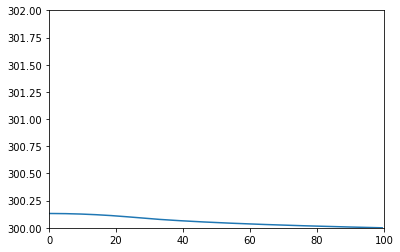

In [6]:
run_animation(100, r, u, xlim=(0, 100), ylim=(300, 302))

## Question 2

We can easily identify this problem as hyperbolic, thus: 

### Implementation

In [7]:
@njit
def u0_(x):
    return np.sin(4*np.pi*x)

@njit
def hyperbolic(h: float, k: float, x0: float, xf: float, t0: float, tf: float, u0: Callable[[float], float]) -> Tuple[np.ndarray]:

    rho = (k/h)**2

    x = np.arange(x0, xf+h, h)
    t = np.arange(t0, tf+k, k)

    LEN_X = len(x)
    LEN_T = len(t)

    sol = np.zeros((LEN_X, LEN_T))

    sol[1:-1, 0] = u0(x)[1:-1]

    sol[1:-1, 1] = 1/2 * rho * (u0(x+h)[1:-1] - u0(x-h)[1:-1]) + (1 - rho) * u0(x)[1:-1]

    for ti in range(2, LEN_T):
        sol[1:-1, ti] = rho*sol[2:, ti-1] + 2*(1 - rho)*sol[1:-1, ti-1] + rho*sol[:-2, ti-1] - sol[1:-1, ti-2]

    return sol, x, t

@njit
def hyperbolic_wraper(dx: float, dt: float, x0: float = 0, xf: float = 1, t0 : float = 0, tf: float = 100, u0: Callable[[float], float] = u0_) -> Tuple[np.ndarray]:
    return hyperbolic(h=dx, k=dt, x0=x0, xf=xf, t0=t0, tf=tf, u0=u0)



### 1. Solve the equation using finite differences.

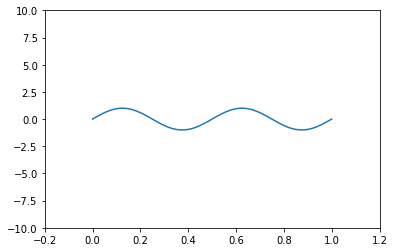

In [8]:
plt.rcParams['animation.html']='jshtml'

dx = 0.01
sol, x, t = hyperbolic_wraper(dx, 0.01)

run_animation(100, x, sol, xlim=(-0.2, 1.2), ylim=(-10, 10))


### 2. Solve the equation up to time $t=100$ with different time-steps $\Delta t$ bigger, equal and smaller than the $\Delta x$. Explain the results.

From class we know that the square of the ratio of the steps: $\rho = (k/h)^2$ should not exceed 1 if the method is to converge. Therefore, the following results are expected:  

Using $k=0.5$ and $h=0.1$, the method explodes

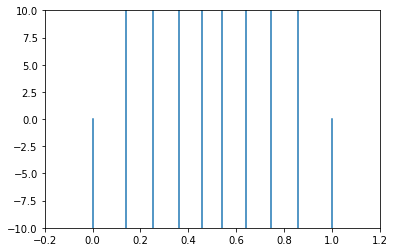

In [9]:
dx = 0.1
dt = 0.5
sol, x, t = hyperbolic_wraper(dx, dt)

run_animation(100, x, sol, xlim=(-0.2, 1.2), ylim=(-10, 10))

Using $k=0.1$ and $h=0.1$, we get a very rough approximation, but the method converges

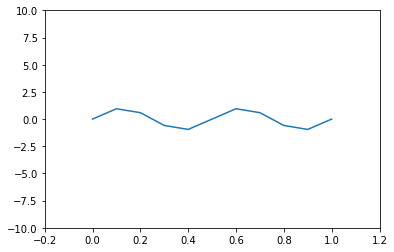

In [10]:
dx = 0.1
dt = 0.1
sol, x, t = hyperbolic_wraper(dx, dt)

run_animation(100, x, sol, xlim=(-0.2, 1.2), ylim=(-10, 10))

Although using smaller equal steps $k=0.01$ and $h=0.01$, the method converges without a problem

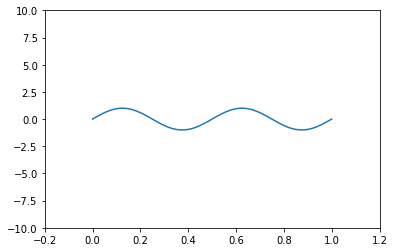

In [11]:
dx = 0.01
dt = 0.01
sol, x, t = hyperbolic_wraper(dx, dt)

run_animation(100, x, sol, xlim=(-0.2, 1.2), ylim=(-10, 10))

Simmilar to the last scenario, using a time step smaller than the space step, for example $k=0.01$ and $h=0.02$, the method converges. We have to take into account that arbitrarily modifying the steps we alterate not only the convergence of the solution but also the solution itself, changing the height and speed of the wave.  

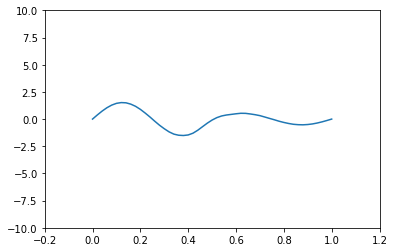

In [12]:
dx = 0.02
dt = 0.01
sol, x, t = hyperbolic_wraper(dx, dt)

run_animation(100, x, sol, xlim=(-0.2, 1.2), ylim=(-10, 10))

Here I let a solution that, by making the ratio just a little but bigger than one, diverges, but it does it in a very cool way

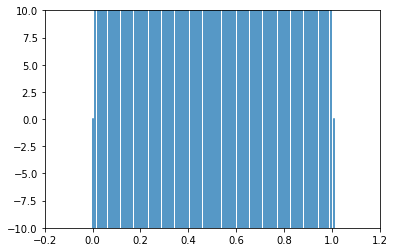

In [13]:
dx = 0.009
dt = 0.01
sol, x, t = hyperbolic_wraper(dx, dt)

run_animation(100, x, sol, xlim=(-0.2, 1.2), ylim=(-10, 10))